In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance

In [3]:
df = pd.read_csv('E:\Documents\Google Drive\Eskwelabs\Sprint 5 - Capstone\data\consolidated_csv_01SUAL_G01.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,06/26/2021,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:05:00 AM,06/26/2021,06/26/2021 12:05:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:10:00 AM,06/26/2021 12:05:00 AM,06/26/2021 12:10:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:15:00 AM,06/26/2021 12:10:00 AM,06/26/2021 12:15:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:20:00 AM,06/26/2021 12:15:00 AM,06/26/2021 12:20:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:25:00 AM,06/26/2021 12:20:00 AM,06/26/2021 12:25:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# Corrected line with tuple comprehension
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [7]:
pd.set_option('display.max_columns', None)

# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]

#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

result_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,06/26/2021,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207765,09/25/2023 11:35:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
207766,09/25/2023 11:40:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
207767,09/25/2023 11:45:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
207768,09/25/2023 11:50:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN


In [65]:
#Set Qmax
Q_max = 647.0

In [66]:
# Bidding curve sampling procedure
def bidding_curve_sampling(row):
    M = 11  # Set M to 10
    delta_q_i = Q_max / M
    q_sp = np.arange(0, Q_max + delta_q_i, delta_q_i)[:M]  # Adjust the range

    p_sp = []
    for i in range(1, M + 1):
        price_col = f'price{i}'
        quantity_col = f'quantity{i}'
        p_sp.append(row[price_col])

    return pd.Series({'P^SP': p_sp, 'q^SP': q_sp})

# Apply bidding curve sampling to each row (DU_i)
bidding_curve_df = result_df.apply(bidding_curve_sampling, axis=1)

# Unifying the data length by normalizing the bidding quantity
def normalize_bidding_curve(row):
    normalized_quantity = row['q^SP'] / Q_max
    return pd.Series({'q(m)': normalized_quantity, 'P^SP': row['P^SP']})

# Apply data normalization to each row
normalized_curve_df = bidding_curve_df.apply(normalize_bidding_curve, axis=1)

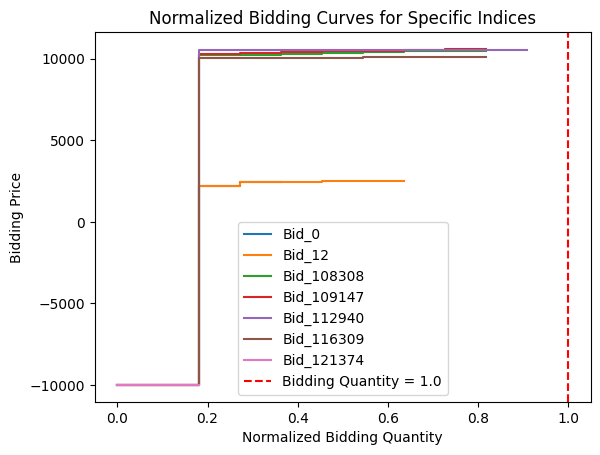

In [67]:
# Indices to plot (adjust as needed)
indices_to_plot = [0, 12, 108308, 109147, 112940, 116309, 121374]

# Plot the bidding curves for the specified indices using plt.step
for index, row in normalized_curve_df.loc[indices_to_plot].iterrows():
    plt.step(row['q(m)'], row['P^SP'], label=f'Bid_{index}', where='post')

plt.axvline(x=1.0, color='red', linestyle='--', label='Bidding Quantity = 1.0')

plt.ylabel('Bidding Price')
plt.xlabel('Normalized Bidding Quantity')
plt.title('Normalized Bidding Curves for Specific Indices')
plt.legend()
plt.show()


In [68]:
bidding_curve_df

,P^SP,q^SP
0,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
1,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
2,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
3,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
4,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
...,...,...
207765,"[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
207766,"[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
207767,"[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
207768,"[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08...","[0.0, 58.81818181818182, 117.63636363636364, 1..."


In [69]:
# Access the 'q^SP' column for the 12th index
contents = bidding_curve_df.at[0, 'q^SP']

# Print the contents
print("Contents of index in 'q^SP' column:")
print(contents)

Contents of index in 'q^SP' column:
[  0.          58.81818182 117.63636364 176.45454545 235.27272727
 294.09090909 352.90909091 411.72727273 470.54545455 529.36363636
 588.18181818]


In [70]:
normalized_curve_df

,q(m),P^SP
0,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
1,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
2,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
3,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
4,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
...,...,...
207765,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08..."
207766,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08..."
207767,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08..."
207768,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08..."


In [71]:
# Access the 'q^SP' column for the 12th index
cont = normalized_curve_df.at[0, 'q(m)']

# Print the contents
print("Contents of index in 'q(m)' column:")
print(cont)

Contents of index in 'q(m)' column:
[0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091]
